In [1]:
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
import re
import os
from PIL import Image 
import math
from skimage.io import imread

# 기존 Tesseract 코드

In [ ]:
# ------------------------- OCR_v1 -------------------------
# OCR 버전마다 전처리 과정이 다름
def OCR_pn(img):
    img = cv2.imread(img) # 이미지 로드
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # 배경에 그레이 적용
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC) # 사이즈 정규화(키우기)
    blur = cv2.GaussianBlur(gray, (5,5), 0) # 이미지에 블러 처리

    # ------------------- 기울기 조정 start -------------------
    canny = cv2.Canny(blur, 700, 350, apertureSize = 5, L2gradient = True) # 이미지 외곽선만 추출
    lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength = 3, maxLineGap = 150) # 직선 찾기

    angle = 0
    maxdim = 0
    # 각도 조정
    if not (lines is None):
        for i in lines:
            xdim = i[0][2] - i[0][0]
            ydim = i[0][3] - i[0][1]
            iangle = math.atan2(ydim, xdim)*180/np.pi
            dim = math.sqrt((xdim * xdim) + (ydim * ydim))
            if abs(angle) < 40 and maxdim < dim:
                maxdim = dim
                angle =iangle

    roih, roiw, roic = img.shape
    matrix = cv2.getRotationMatrix2D((roiw/2, roih/2), angle, 1)
    roi = cv2.warpAffine(img, matrix, (roiw, roih))
    # ------------------- 기울기 조정 fin -------------------

    roi = cv2.resize(roi, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur_2 = cv2.GaussianBlur(roi, (5,5), 0)
    
    plate_num = ""
    try:
        # tesseract OCR 적용
        text = pytesseract.image_to_string(blur_2, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1') # whitelist: 숫자만 인식
        plate_num = re.sub('[\W_]+', '', text) # 특수문자 제거
    except:
        text = None
        
    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]


# ------------------------- OCR_v2 -------------------------
def OCR_pn2(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    plate_num = ""
    try:
        text = pytesseract.image_to_string(blur, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1')
        plate_num = re.sub('[\W_]+', '', text)            
    except:
        text = None

    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]


# ------------------------- OCR_v3 -------------------------
def OCR_pn3(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # ------------------- 기울기 조정 start -------------------
    canny = cv2.Canny(blur, 700, 350, apertureSize = 5, L2gradient = True)
    lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength = 3, maxLineGap = 150)

    angle = 0
    maxdim = 0
    if not (lines is None):
        for i in lines:
            xdim = i[0][2] - i[0][0]
            ydim = i[0][3] - i[0][1]
            iangle = math.atan2(ydim, xdim)*180/np.pi
            dim = math.sqrt((xdim * xdim) + (ydim * ydim))
            if abs(angle) < 40 and maxdim < dim:
                maxdim = dim
                angle =iangle

    roih, roiw, roic = img.shape
    matrix = cv2.getRotationMatrix2D((roiw/2, roih/2), angle, 1)
    roi = cv2.warpAffine(img, matrix, (roiw, roih))
    # ------------------- 기울기 조정 fin -------------------

    gray_2 = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    gray_2 = cv2.resize(gray_2, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur_2 = cv2.GaussianBlur(gray_2, (5,5), 0)

    ## 이미지 흑백 대조하기, 최적 임계값을 자동으로 추출하는 Otsus 사용
    ret, thresh = cv2.threshold(blur_2, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    ## 확장을 위한 커널 생성
    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    ## 글씨 이미지 크기 확장
    dilation = cv2.dilate(thresh, rect_kern, iterations = 1)

    blur_3 = cv2.GaussianBlur(dilation, (5,5), 0)
    
    plate_num = ""
    try:
        text = pytesseract.image_to_string(blur_3, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1')
        plate_num = re.sub('[\W_]+', '', text)            
    except:
        text = None
    
    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]
            
        
# ------------------------- OCR_v4 -------------------------
def OCR_bn(img):
    img = cv2.imread(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    ## 이미지 흑백 대조하기, 최적 임계값을 자동으로 추출하는 Otsus 사용
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    ## 확장을 위한 커널 생성
    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    ## 글씨 이미지 크기 확장
    dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
    blur_2 = cv2.GaussianBlur(dilation, (5,5), 0)
    
    plate_num = ""
    try:
        text = pytesseract.image_to_string(blur_2, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1')            
    except:
        text = None
        
    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]

# 이미지 후처리 테스트
## 1. Tesseract

In [ ]:
def OCR(img):
    plate_num = ""
    try:
        text = pytesseract.image_to_string(img, config='-c tessedit_char_whitelist=0123456789 --psm 7 --oem 1')            
    except:
        text = None
        
    plate_num = re.sub('[\W_]+', '', text)   
    return plate_num[-4:]

In [ ]:
import time
start = time.time()

bus_num_fr_path = 'yolov5/runs/hub/exp/crops/bus_num_fr/'
file_list = os.listdir(bus_num_fr_path)
result_list = list()

for file in file_list:
    folder_name = file.split(' ')[0]
    try:
        img = cv2.imread(os.path.join(bus_num_fr_path, file))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        edged = cv2.Canny(blurred, 700, 350, apertureSize = 5, L2gradient = True)
        result = OCR(edged)
    except:
        result = 'None'

    if result == folder_name:
        result_list.append(1)
    else:
        result_list.append(0)

print(time.time() - start)
sum(result_list)/len(result_list)

## 2. easyocr

In [7]:
import time
import easyocr

In [9]:
bus_num_fr_path = 'yolov5/runs/hub/exp/crops/bus_num_fr/'
file_list = os.listdir(bus_num_fr_path)
result_list = list()
reader = easyocr.Reader(['ar'])

start = time.time()
for file in file_list:
    folder_name = file.split(' ')[0]
    try:
#         blurred = cv2.GaussianBlur(img, (3, 3), 0)
        result = reader.readtext(cv2.imread(os.path.join(bus_num_fr_path, file)))[0][-2]
        result = re.findall('\d+', result)
    except:
        result = 'None'

    if folder_name in result:
        result_list.append(1)
    else:
        result_list.append(0)

print(time.time() - start)
sum(result_list)/len(result_list)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


165.5053095817566


0.815592203898051

## 필터 테스트

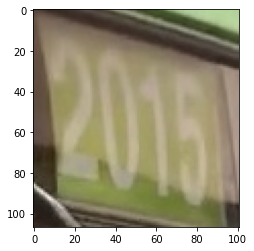

In [10]:
test_img = 'yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg'

img = cv2.imread('yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg')

plt.imshow(img)

### 1. GaussianBlur test

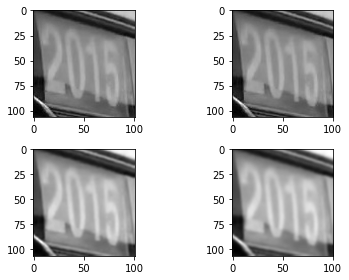

In [11]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

fig = plt.figure()
sub1 = fig.add_subplot(2,2,1)
sub2 = fig.add_subplot(2,2,2)
sub3 = fig.add_subplot(2,2,3)
sub4 = fig.add_subplot(2,2,4)


sub1.imshow(gray, cmap='gray')
blurred1 = cv2.GaussianBlur(gray, (1, 1), 0)
sub2.imshow(blurred1, cmap='gray')
blurred2 = cv2.GaussianBlur(gray, (3, 3), 0) ## 이 조합 제일 좋음 0.49
sub3.imshow(blurred2, cmap='gray')
blurred3 = cv2.GaussianBlur(gray, (5, 5), 0)
sub4.imshow(blurred3, cmap='gray')

plt.tight_layout()
plt.show()

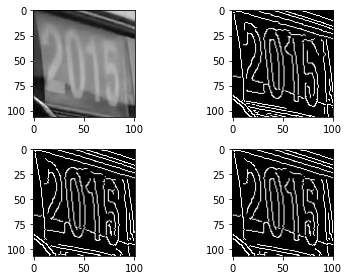

In [12]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

fig = plt.figure()
sub1 = fig.add_subplot(2,2,1)
sub2 = fig.add_subplot(2,2,2)
sub3 = fig.add_subplot(2,2,3)
sub4 = fig.add_subplot(2,2,4)


sub1.imshow(gray, cmap='gray')

blurred1 = cv2.GaussianBlur(gray, (1, 1), 0)
edged1 = cv2.Canny(blurred1, 700, 350, apertureSize = 5, L2gradient = True)
sub2.imshow(edged1, cmap='gray')

blurred2 = cv2.GaussianBlur(gray, (3, 3), 0)
edged2 = cv2.Canny(blurred, 10, 50, 255)
sub3.imshow(edged2, cmap='gray')

blurred3 = cv2.GaussianBlur(gray, (5, 5), 0)
edged3 = cv2.Canny(blurred, 10, 50, 255)
sub4.imshow(edged3, cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
edged = cv2.Canny(blurred, 10, 50, 255)

### 2. HE test

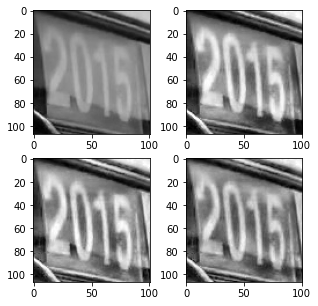

In [13]:
test_img = 'yolov5/runs/hub/exp/crops/bus_num_fr/2015 (26).jpg'
img = cv2.imread(test_img)
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(5, 5))
fig_1 = fig.add_subplot(2,2,1)
fig_2 = fig.add_subplot(2,2,2)
fig_3 = fig.add_subplot(2,2,3)
fig_4 = fig.add_subplot(2,2,4)

# create a CLAHE object (Arguments are optional).
clahe1 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(3,3))
cl1 = clahe1.apply(gray_image)

clahe2 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(5,5))
cl2 = clahe2.apply(gray_image)

clahe3 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(7,7))
cl3 = clahe3.apply(gray_image)

fig_1.imshow(gray_image, cmap='gray')
fig_2.imshow(cl1, cmap='gray')
fig_3.imshow(cl2, cmap='gray')
fig_4.imshow(cl3, cmap='gray')
plt.show()

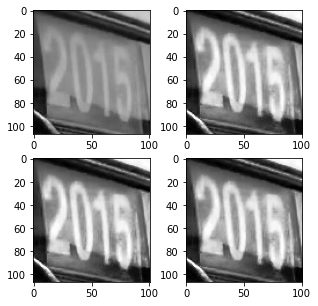

In [14]:
fig = plt.figure(figsize=(5, 5))
fig_1 = fig.add_subplot(2,2,1)
fig_2 = fig.add_subplot(2,2,2)
fig_3 = fig.add_subplot(2,2,3)
fig_4 = fig.add_subplot(2,2,4)

# create a CLAHE object (Arguments are optional).
clahe1 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(2,2))
cl1 = clahe1.apply(gray_image)

clahe2 = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(2,2))
cl2 = clahe2.apply(gray_image)

clahe3 = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(2,2))
cl3 = clahe3.apply(gray_image)

fig_1.imshow(gray_image, cmap='gray')
fig_2.imshow(cl1, cmap='gray')
fig_3.imshow(cl2, cmap='gray')
fig_4.imshow(cl3, cmap='gray')
plt.show()

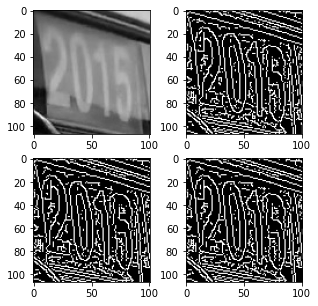

In [15]:
fig = plt.figure(figsize=(5, 5))
fig_1 = fig.add_subplot(2,2,1)
fig_2 = fig.add_subplot(2,2,2)
fig_3 = fig.add_subplot(2,2,3)
fig_4 = fig.add_subplot(2,2,4)

# create a CLAHE object (Arguments are optional).
clahe1 = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(2,2))
cl1 = clahe1.apply(gray_image)
edged1 = cv2.Canny(cl1, 10, 50, 255)

clahe2 = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(2,2))
cl2 = clahe2.apply(gray_image)
edged2 = cv2.Canny(cl2, 10, 50, 255)

clahe3 = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(2,2))
cl3 = clahe3.apply(gray_image)
edged3 = cv2.Canny(cl3, 10, 50, 255)

fig_1.imshow(gray_image, cmap='gray')
fig_2.imshow(edged1, cmap='gray')
fig_3.imshow(edged2, cmap='gray')
fig_4.imshow(edged3, cmap='gray')
plt.show()